In [188]:
import os
import numpy as np
from scipy.spatial.distance import cdist

In [189]:
len(os.listdir('data/waterbind/'))

17092

In [190]:
from openbabel import openbabel

In [191]:
openbabel

<module 'openbabel.openbabel' from '/usr/local/lib/python3.10/dist-packages/openbabel/openbabel.py'>

In [192]:
ground_truth_unfiltered_dir = 'data/waterbind/'
ground_truth_bfactor40_dir = 'data/waterbind_bf40/'
inference_val_unfiltered_dir = 'inference_out/DiffWaterInference_test_rr1'
inference_test_unfiltered_dir = 'inference_out/DiffWaterInference_test_rr1_L20'

In [193]:
file_names = os.listdir(inference_test_unfiltered_dir)

FileNotFoundError: [Errno 2] No such file or directory: 'inference_out/DiffWaterInference_test_rr1_L20'

In [194]:
file_names[:5]

NameError: name 'file_names' is not defined

In [195]:
def read_inference_pdb_files(directory):
    pdb_files = {}
    for filename in os.listdir(directory):
        if filename.endswith(".pdb"):
            pdb_id = filename.split('_')[0]
            pdb_files[pdb_id] = os.path.join(directory, filename)
    return pdb_files

In [196]:
def read_ground_truth_pdb_files(directory, predicted_ids):
    pdb_files = {}
    for subdir in os.listdir(directory):
        if subdir in predicted_ids:
            subdir_path = os.path.join(directory, subdir)
            water_pdb_path = os.path.join(subdir_path, subdir + "_water.pdb")
            if os.path.exists(water_pdb_path):
                pdb_files[subdir] = water_pdb_path
    return pdb_files

In [197]:
def extract_last_inference_model(pdb_file_path):
    models_content = []
    current_model = []
    reading_model = False

    with open(pdb_file_path, 'r') as file:
        for line in file:
            if line.startswith("MODEL"):
                reading_model = True  # Start reading a new model
                current_model = []    # Reset the current model list
            elif line.startswith("ENDMDL"):
                reading_model = False
                models_content.append("".join(current_model))  # Store the model's content
            elif reading_model:
                current_model.append(line)  # Collect lines that belong to the current model
    
    last_model = models_content[-1].split('\n')[1:][:-1]
    return last_model

In [198]:
def extract_truth_water_pos(pdb_file_path):
    with open(pdb_file_path, 'r') as file:
        lines = file.readlines()
    true_water_pos = []
    for line in lines:
        parts = line.split()
        if len(parts) < 6:
            continue
        try:
            x = float(line[30:38].strip())
            y = float(line[38:46].strip())
            z = float(line[46:54].strip())
        except:
            continue
        true_water_pos.append(tuple((x, y, z)))
    return np.array(true_water_pos)

In [199]:
def extract_inference_water_pos(pdb_file_path):
    last_inference_model = extract_last_inference_model(pdb_file_path)
    inference_water_pos = []
    for line in last_inference_model:
        parts = line.split()
        if len(parts) < 6:
            continue
        try:
            x = float(line[30:38].strip())
            y = float(line[38:46].strip())
            z = float(line[46:54].strip())
        except:
            continue
        inference_water_pos.append(tuple((x, y, z)))
    inference_water_pos = np.array(inference_water_pos)
    filtered_inference_water_pos = inference_water_pos[~np.all(inference_water_pos == 0, axis=1)]
    return filtered_inference_water_pos

In [200]:
def calculate_rmsd(true_coords, predicted_coords):
    diff = np.array(true_coords) - np.array(predicted_coords)
    return np.sqrt((diff ** 2).sum() / len(true_coords))

In [201]:
def calculate_coverage_rate(true_water_pos, inference_water_pos, cutoff=1):
    distance_matrix = cdist(inference_water_pos, true_water_pos)
    # Initialize a variable to count the number of predicted waters within the cutoff distance of any true water
    coverage_count = 0
    used_true_water_pos = set()  # To keep track of true waters that have been matched

    for row in distance_matrix:
        # Find the index of the nearest true water molecule for each predicted water molecule
        nearest_true_water_index = np.argmin(row)
        if row[nearest_true_water_index] <= cutoff and nearest_true_water_index not in used_true_water_pos:
            coverage_count += 1
            used_true_water_pos.add(nearest_true_water_index)  # Mark this true water as matched

    return coverage_count / len(true_water_pos)

In [202]:
def calculate_precision(true_water_pos, inference_water_pos, cutoff=1):
    distance_matrix = cdist(inference_water_pos, true_water_pos)
    coverage_count = 0
    for row in distance_matrix:
        # Find the index of the nearest true water molecule for each predicted water molecule
        nearest_true_water_index = np.argmin(row)
        if row[nearest_true_water_index] <= cutoff:
            coverage_count += 1
    return coverage_count / len(inference_water_pos)

In [203]:
def calculate_val_average_coverage_rate_and_precision(cutoff=1):
    inference_pdb_files = read_inference_pdb_files(inference_val_unfiltered_dir)
    ground_truth_pdb_files = read_ground_truth_pdb_files(ground_truth_unfiltered_dir, inference_pdb_files.keys())
    pdb_ids = list(inference_pdb_files.keys())
    all_coverage_rate = []
    all_precision = []
    for pdb_id in pdb_ids:
        inference_water_pos = extract_inference_water_pos(inference_pdb_files[pdb_id])
        true_water_pos = extract_truth_water_pos(ground_truth_pdb_files[pdb_id])
        water_coverage_rate = calculate_coverage_rate(true_water_pos, inference_water_pos, cutoff)
        water_precision = calculate_precision(true_water_pos, inference_water_pos, cutoff)
        all_coverage_rate.append(water_coverage_rate)
        all_precision.append(water_precision)
        
    average_coverage_rate = np.mean(all_coverage_rate)
    average_precision = np.mean(all_precision)
    print(f'Max Coverage Rate within Cutoff {cutoff}A: ', max(all_coverage_rate))
    print(f'Max Precision within Cutoff {cutoff}A: ', max(all_precision))
    print(f'Average Coverage Rate within Cutoff {cutoff}A: ', average_coverage_rate)
    print(f'Average Precision within Cutoff {cutoff}A: ', average_precision)
    return average_coverage_rate, average_precision

In [204]:
from tqdm import tqdm

def calculate_test_average_coverage_rate_and_precision(cutoff=1, queit=False):
    inference_pdb_files = read_inference_pdb_files(inference_test_unfiltered_dir)
    ground_truth_pdb_files = read_ground_truth_pdb_files(ground_truth_unfiltered_dir, inference_pdb_files.keys())
    pdb_ids = list(inference_pdb_files.keys())
    all_coverage_rate = []
    all_precision = []
    
    coverage_rate_dict = {}
    precision_dict = {}
    
    for i in tqdm(range(len(pdb_ids))):
        pdb_id = pdb_ids[i]
        inference_water_pos = extract_inference_water_pos(inference_pdb_files[pdb_id])
#         print('inference_water_pos: ', inference_water_pos.shape)

        true_water_pos = extract_truth_water_pos(ground_truth_pdb_files[pdb_id])
#         print('true_water_pos: ', true_water_pos.shape)
#         return
        
        water_coverage_rate = calculate_coverage_rate(true_water_pos, inference_water_pos, cutoff)
        water_precision = calculate_precision(true_water_pos, inference_water_pos, cutoff)
        
        all_coverage_rate.append(water_coverage_rate)
        all_precision.append(water_precision)
        
        coverage_rate_dict[pdb_id] = water_coverage_rate
        precision_dict[pdb_id] = water_precision
        
    average_coverage_rate = np.mean(all_coverage_rate)
    average_precision = np.mean(all_precision)
    
    max_coverage_rate_pdb_id = max(coverage_rate_dict, key=coverage_rate_dict.get)
    min_coverage_rate_pdb_id = min(coverage_rate_dict, key=coverage_rate_dict.get)
        
    max_precision_pdb_id = max(precision_dict, key=precision_dict.get)
    min_precision_pdb_id = min(precision_dict, key=precision_dict.get)
    
    if not queit:
        print(f'Max Coverage Rate within Cutoff {cutoff}A: {coverage_rate_dict[max_coverage_rate_pdb_id]}, PDB ID: {max_coverage_rate_pdb_id}')
        print(f'Max Precision within Cutoff {cutoff}A: {precision_dict[max_precision_pdb_id]}, PDB ID: {max_precision_pdb_id}')
        print(f'Min Coverage Rate within Cutoff {cutoff}A: {coverage_rate_dict[min_coverage_rate_pdb_id]}, PDB ID: {min_coverage_rate_pdb_id}')
        print(f'Min Precision within Cutoff {cutoff}A: {precision_dict[min_precision_pdb_id]}, PDB ID: {min_precision_pdb_id}')
        print()
        print(f'Average Coverage Rate within Cutoff {cutoff}A: {average_coverage_rate}')
        print(f'Average Precision within Cutoff {cutoff}A: {average_precision}')
        print()
    
    return average_coverage_rate, average_precision, coverage_rate_dict

In [205]:
inference_test_unfiltered_dir = 'inference_out/DiffWater_Inference_val_rr1_L20'

In [206]:
len(os.listdir(inference_test_unfiltered_dir))

1717

In [207]:
_,_,coverage_rate_dict =  calculate_test_average_coverage_rate_and_precision(cutoff=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1709/1709 [00:08<00:00, 193.90it/s]

Max Coverage Rate within Cutoff 1A: 0.7383177570093458, PDB ID: 5P4N
Max Precision within Cutoff 1A: 0.7643504531722054, PDB ID: 5PLK
Min Coverage Rate within Cutoff 1A: 0.0, PDB ID: 5RVR
Min Precision within Cutoff 1A: 0.0, PDB ID: 5RVR

Average Coverage Rate within Cutoff 1A: 0.30848817273120765
Average Precision within Cutoff 1A: 0.3612227775494319



In [209]:
coverage_values = list(coverage_rate_dict.values())

min_value = np.min(coverage_values)
max_value = np.max(coverage_values)
mean_value = np.mean(coverage_values)
median_value = np.median(coverage_values)
std_dev = np.std(coverage_values)
percentile_25 = np.percentile(coverage_values, 25)
percentile_50 = np.percentile(coverage_values, 50)
percentile_75 = np.percentile(coverage_values, 75)

print(f"Summary of Coverage Rates:")
print(f"Min: {min_value}")
print(f"Max: {max_value}")
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_dev}")
print(f"25th Percentile: {percentile_25}")
print(f"50th Percentile (Median): {percentile_50}")
print(f"75th Percentile: {percentile_75}")

Summary of Coverage Rates:
Min: 0.0
Max: 0.7383177570093458
Mean: 0.30848817273120765
Median: 0.28065395095367845
Standard Deviation: 0.11208820255729283
25th Percentile: 0.2358490566037736
50th Percentile (Median): 0.28065395095367845
75th Percentile: 0.35398230088495575


In [215]:
filtered_keys = [key for key, value in coverage_rate_dict.items() if value < 0.2]
len(filtered_keys)
remaining_values = [value for key, value in coverage_rate_dict.items() if key not in filtered_keys]
np.mean(remaining_values)
# print(f"Keys with coverage rate < 0.2: {filtered_keys}")

0.3232073793113151

In [216]:
len(filtered_keys)

160

In [217]:
for key in filtered_keys:
    print(key, coverage_rate_dict[key])

2IDQ 0.18235294117647058
3GQ1 0.16831683168316833
4CST 0.17266187050359713
4GJZ 0.18101545253863136
8VMS 0.18090452261306533
4KZV 0.1984126984126984
4PJ2 0.15950920245398773
2B97 0.18473895582329317
7NYO 0.10619469026548672
7KFO 0.19834710743801653
4A8U 0.19487179487179487
1IWT 0.16996047430830039
1SL9 0.1971153846153846
1SQZ 0.19369369369369369
4Q68 0.1991869918699187
4YSI 0.1865079365079365
4LOV 0.19081272084805653
5W2F 0.19545454545454546
2H5C 0.1473429951690821
1WQW 0.15625
5RVR 0.0
5Y1F 0.0
8AZX 0.1888412017167382
1RFK 0.1277533039647577
2Y72 0.17784256559766765
6S5W 0.15591397849462366
7Y43 0.15151515151515152
5IEL 0.024096385542168676
8IS2 0.1791044776119403
3EAZ 0.1743119266055046
7P6S 0.18222222222222223
5L2V 0.19435215946843853
3F04 0.15673981191222572
8R5K 0.17525773195876287
2P52 0.1919191919191919
2XL6 0.1597444089456869
5LND 0.1729957805907173
8H0R 0.19230769230769232
6F7R 0.0
5EL9 0.19895287958115182
2UV4 0.16666666666666666
7OKL 0.1711229946524064
5FBF 0.195505617977528

In [28]:
for key in filtered_keys:
    print(key, coverage_rate_dict[key])

6LUZ 0.0
4CO0 0.14919354838709678
8IWI 0.1368421052631579
5XX2 0.12012987012987013
5RCE 0.0
5S94 0.0
6RLX 0.05714285714285714
7RXX 0.0
1HQJ 0.12213740458015267
5KL3 0.1388888888888889
6LUX 0.0
2NLF 0.11084905660377359
6LVA 0.0
5Z0X 0.0
2JE4 0.06983240223463687
4OQ8 0.1375
6HG7 0.14864864864864866
4CO3 0.0761904761904762


In [29]:
def save_bad_list(element_list, file_name):
    with open(file_name, 'w') as file:
        for element in element_list:
            file.write(f"{element}\n")
    print(f"List has been written to {file_name}")

In [238]:
bad_test_list = ['3VPY', '4Q27', '5K9F', '1IFC', '2Q8K', '4GEI', '1LQV', '4I9Y', '7CKV', '3PJP', '2OG4', '3PG0', '4ESU', '5LDG', '3F9X', '3BQX', '3HSH', '3C9A', '6W6B', '3FEU', '3HH7', '7ZSF', '2GLZ', '4AIV', '3MNM', '1UKF', '3EFY', '3BT5', '1J98', '1WCW', '2IBN', '5TR9', '8U5E', '3QRL', '1A62']

In [239]:
save_bad_list(bad_test_list, 'bad_test_list.txt')

List has been written to bad_test_list.txt


In [224]:
bad_val_list = ['6YZG', '2VKJ', '3CVE', '1RFS', '4YTD', '1TIQ', '6PNY', '1E2W', '5UC0', '7DVN', '8F43', '2V9L', '6FJV', '5ONN', '6LCH', '2QIP', '2QT1', '1WLU', '2GWM', '2J05', '3DM8', '3IQT', '4Z2O', '6CPB', '3CWR', '1JB3', '6Q3Q', '1Z1S', '3P42', '1OIS', '5XSO', '2HW2', '2VO8', '2J8G', '4DUI', '3S2R', '4NOB', '1M2D', '3KH7', '1SK4', '3L4E', '5E10']

In [240]:
save_bad_list(bad_val_list, 'bad_val_list.txt')

List has been written to bad_val_list.txt


In [235]:
bad_train_list = ['3C4B', '2H7Z', '3HFO', '4PUX', '1E29', '1UIX', '6MQ7', '3CHM', '1XKR', '1IJQ', '3N8B', '1T4A', '4JVU', '4YE7', '5G38', '4RZ9', '1BS0', '7PQK', '8QQC', '1NAR', '2WCW', '5EL9', '1S4K', '1VAJ', '2QQ9', '3A57', '4NAZ', '4UU5', '3E0Z', '3U9J', '3SWK', '7X2E', '7YH3', '2XCZ', '6OOD', '2B0V', '7EAD', '5A6S', '5FA8', '3D4E', '2Z0T', '3DMN', '1DZK', '3L1E', '8A9O', '3T90', '3I1A', '3NPD', '2HLV', '2FU0', '2EBN', '6T84', '5NJO', '3KBB', '4NX1', '2X5H', '4TZH', '4MLM', '3EJG', '5HOP', '1F7L', '2P12', '6ZPJ', '1UAR', '2QNT', '3BYP', '2OPC', '1U7I', '8G64', '3NPH', '7ZVO', '3V68', '4F54', '8GYN', '1PKO', '8E2B', '1MY7', '3E0H', '5YHY', '5U2L', '2QGS', '6KJW', '2D28', '4JVW', '8SBN', '1Q5Z', '6CD7', '3BPV', '4TYZ', '3CIJ', '3U3Z', '4H60', '1IO2', '5MLT', '3A2Z', '2FWV', '2DQL', '4EPZ', '2OKU', '2E0Q', '6TAB', '1VMB', '3HX3', '3P2T', '3G89', '1KYF', '5DJE', '1HTW', '6YDR', '6FQ1', '3CJS', '1F2T', '5CTD', '3MGD', '4F8L', '1NKR', '6SJH', '3MWZ', '2XUV', '3CBN', '3HRG', '2EKL', '5FAA', '3CM3', '7RSW', '3MC3', '5ITQ', '4D0Q', '3D3B', '3FFV', '3V7B', '3MB5', '3D79', '6DX1', '6BSC', '1GL2', '5G3X', '7LGC', '8B2Q', '1XSV', '3V0S', '3MST', '3GS9', '1KMV', '5GUQ', '7T1E', '6CNW', '5YWR', '2YZQ', '4Y1S', '5JWO', '4Q8K', '1O1Y', '1VP8', '1WRD', '1WAD', '3L7H', '2AGK', '3F4A', '7KOS', '4O9K', '1HXI', '1WMS', '1W4V', '2Q0Y', '7NYO', '4Z3G', '5J0K', '4ZYA', '1WMH', '6DGG', '6G5P', '3U1L', '1UPI', '2P6Y', '8D5H', '4P82', '1D0D', '4JQF', '4N73', '6XHZ', '3G36', '4Q29', '1ZUH', '4LRJ', '3LAA', '4IIO', '1ZCH', '2IAI', '2NRK', '4QT3', '3KOS', '3M9L', '4TMX', '3BGY', '2PLR', '5OXZ', '8C4P', '5EHA', '1VR9', '1GMU', '2BKY', '4TQX', '6JM5', '3TQ8', '5HGZ', '4YBM', '6SGF', '1FIT', '7WME', '3FZG', '5AR6', '4J9Y', '3HKM', '2CAL', '3GGY', '6U2S', '1VR8', '6GI4', '1T6T', '2IF5', '4P40', '5A98', '7DF2']

In [241]:
save_bad_list(bad_train_list, 'bad_train_list.txt')

List has been written to bad_train_list.txt


In [76]:
import matplotlib.pyplot as plt

def calculate_coverage_rates_for_folders(base_dir, num_folders, cutoff=1):
    coverage_rates = []
    folder_names = []
    
    for num in range(1, num_folders + 1):
        folder_name = f"DiffWaterInference_test_rr{num}_L20"
        folder_path = f"{base_dir}/{folder_name}"
        
        # Set the global variables or parameters to point to the current folder
        global inference_test_unfiltered_dir
        inference_test_unfiltered_dir = folder_path
        
        # Calculate coverage rate and precision for the current folder
        average_coverage_rate, _ = calculate_test_average_coverage_rate_and_precision(cutoff, queit=True)
        
        # Store the results
        coverage_rates.append(average_coverage_rate)
        folder_names.append(f"W/L={num}")
    
    return coverage_rates, folder_names, cutoff

def plot_coverage_rates(coverage_rates, folder_names, cutoff=1):
    plt.figure(figsize=(10, 6))
    
    plt.plot(folder_names, coverage_rates, marker='o', label='Average Coverage Rate')
    
    for i, rate in enumerate(coverage_rates):
        plt.text(i, rate, f'{rate:.2f}', ha='center', va='bottom')
    
    plt.xlabel('Ratio')
    plt.ylabel('Average Coverage Rate')
    plt.title(f'Coverage Rate with Cutoff {cutoff}A')
    plt.xticks(rotation=0, ha='center')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'average_coverage_rate_cutoff_{cutoff}.png')
    plt.show()

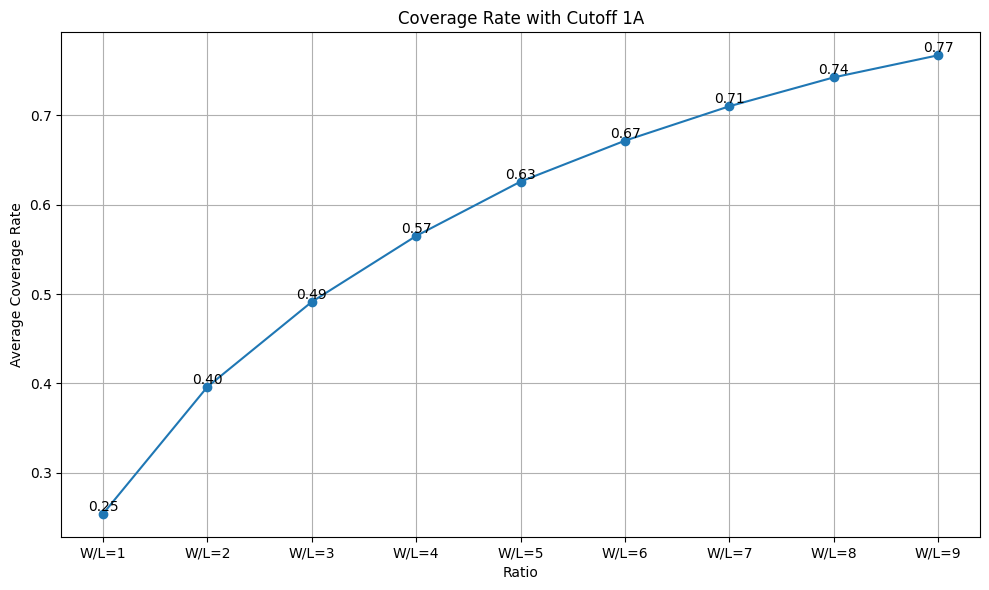

In [77]:
# Usage
base_dir = 'inference_out'
num_folders = 9
cutoff = 1

coverage_rates, folder_names, cutoff = calculate_coverage_rates_for_folders(base_dir, num_folders, cutoff)
plot_coverage_rates(coverage_rates, folder_names, cutoff)

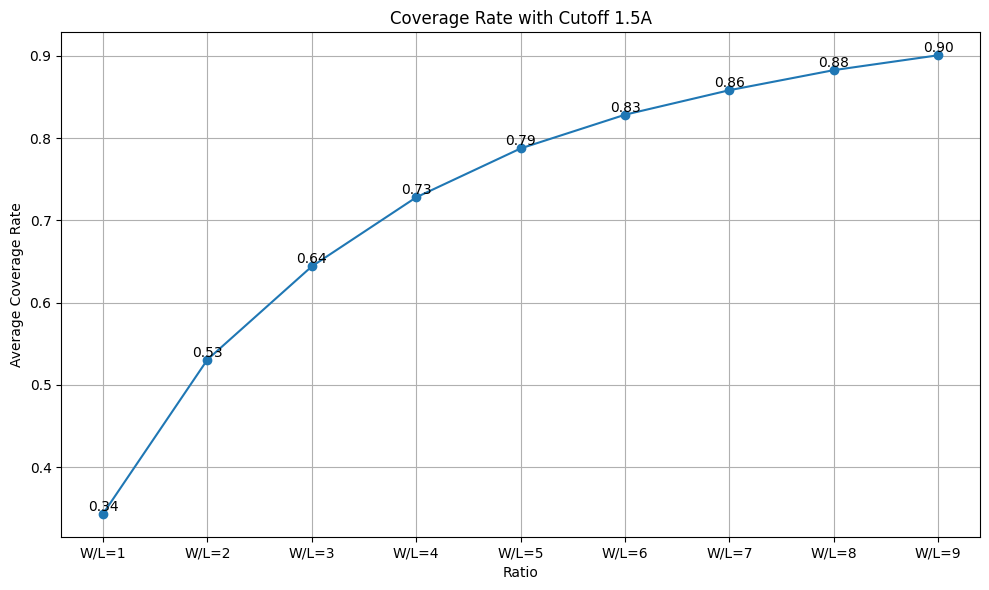

In [78]:
cutoff = 1.5

coverage_rates, folder_names, cutoff = calculate_coverage_rates_for_folders(base_dir, num_folders, cutoff)
plot_coverage_rates(coverage_rates, folder_names, cutoff)

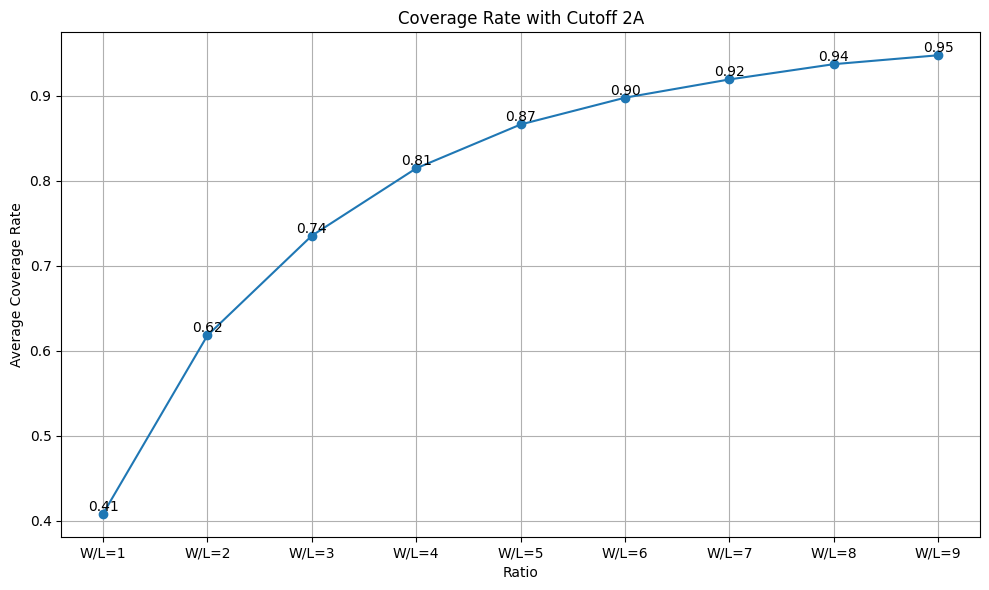

In [79]:
cutoff = 2

coverage_rates, folder_names, cutoff = calculate_coverage_rates_for_folders(base_dir, num_folders, cutoff)
plot_coverage_rates(coverage_rates, folder_names, cutoff)